### This CNN uses three conv-pool blocks, with doubling number of filters used per block. Two dense layers at the end.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
import os
root_logdir = os.path.join(os.curdir, "conv_pool_batch_large_kernel_lower_learning_balance_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [3]:
batch_size = 32
target_size = (512,384)
n_training_images = 2051

train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  rotation_range=10,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  validation_split=0.15)

test_datagen = ImageDataGenerator(rescale=1./255, 
                                  validation_split=0.15)


train_generator = train_datagen.flow_from_directory('../data/images/train',
                                                    color_mode='rgb',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    subset='training')

validation_generator = test_datagen.flow_from_directory('../data/images/train',
                                                       color_mode='rgb',
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='categorical',
                                                       subset='validation')

hd_datagen = ImageDataGenerator(rescale=1./255)

holdout_generator = hd_datagen.flow_from_directory('../data/images/holdout',
                                                       color_mode='rgb',
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='categorical',
                                                       shuffle=False)

labels = (train_generator.class_indices)
labels = dict((v, k) for k,v in labels.items())
labels


Found 1937 images belonging to 6 classes.
Found 339 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [39]:
model=Sequential()

model.add(Conv2D(32, (7,7), strides=4, padding='same', input_shape=(target_size[0], target_size[1], 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3, strides=2))

model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=n_training_images*10//batch_size,
#     decay_rate=0.9)


opt = keras.optimizers.Adam(learning_rate=.0001)

model.compile(loss='categorical_crossentropy',
             optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 96, 32)       4736      
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 96, 32)       128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 47, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 63, 47, 64)        51264     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 23, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 23, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 11, 128)      

In [12]:
import numpy as np

In [8]:
from sklearn.utils.class_weight import compute_class_weight

In [16]:
class_wts = {0:393., 1:491., 2:400., 3:584., 4:472., 5:127.}
cw = 2467 / (6*np.array([393, 491, 400, 584, 472, 127]))
cw_dict = {i:x for i, x in enumerate(cw)}

In [40]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('conv_pool_batch_large_kernel_lower_learning_balance.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())


history = model.fit(
    train_generator,
    validation_data = validation_generator, 
    verbose=1,
    epochs = 1000,
    class_weight=cw_dict,
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/1000
61/61 [==============================] - 165s 3s/step - loss: 1.6926 - accuracy: 0.3126 - val_loss: 1.7790 - val_accuracy: 0.3038
Epoch 2/1000
61/61 [==============================] - 143s 2s/step - loss: 1.4250 - accuracy: 0.4416 - val_loss: 1.7208 - val_accuracy: 0.3864
Epoch 3/1000
61/61 [==============================] - 144s 2s/step - loss: 1.2307 - accuracy: 0.5164 - val_loss: 1.6840 - val_accuracy: 0.3835
Epoch 4/1000
61/61 [==============================] - 143s 2s/step - loss: 1.2189 - accuracy: 0.5095 - val_loss: 1.6034 - val_accuracy: 0.4838
Epoch 5/1000
61/61 [==============================] - 142s 2s/step - loss: 1.0800 - accuracy: 0.5638 - val_loss: 1.6045 - val_accuracy: 0.3746
Epoch 6/1000
61/61 [==============================] - 146s 2s/step - loss: 1.0793 - accuracy: 0.5622 - val_loss: 1.4689 - val_accuracy: 0.4277
Epoch 7/1000
61/61 [==============================] - 141s 2s/step - loss: 1.0287 - accuracy: 0.5945 - val_loss: 1.4066 - val_accuracy: 0.4572

In [41]:
score = model.evaluate(holdout_generator
                       , verbose=0)
print('Holdout accuracy:', score[1])

Holdout accuracy: 0.892430305480957


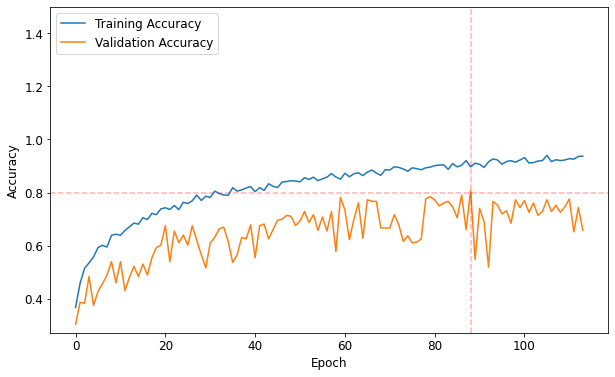

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.axvline(88, linestyle='--', color='r', alpha=.3)
plt.axhline(.8, linestyle='--', color='r', alpha=.3)
plt.ylim(top=1.5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

In [43]:
max(history.history['val_accuracy'])

0.8082596063613892

In [71]:
batch = next(holdout_generator)

In [72]:
batch[1]

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [44]:
import numpy as np
from collections import Counter
import pandas as pd

In [137]:
def show_incorrect_batch_predictions(model, batch, label_dict):
    probs = model.predict(batch[0])
    predictions = np.argmax(probs, axis=1)
    target = np.argmax(batch[1], axis=1)
    incorrect = np.where(predictions != target)
    top3_idx = np.argsort(probs, axis=1)[:,-1:-4:-1]
#     fig, axs = plt.subplots(len(incorrect[0]), 1, figsize=(9, 6*len(incorrect[0])))
    for idx, image in enumerate(incorrect[0]):
        fig, ax = plt.subplots()
        ax.imshow(batch[0][image])
        ax.axis('off')
        ax.set_title(f'Target: {label_dict[target[image]]}')
        textstr = f'''Top 3 Probabilities: \n 1. {label_dict[top3_idx[image, 0]]:}: {probs[image, top3_idx[image, 0]]:.2f} \n 2. {label_dict[top3_idx[image, 1]]}: {probs[image, top3_idx[image, 1]]:.2f} \n 3. {label_dict[top3_idx[image, 2]]}: {probs[image, top3_idx[image, 2]]:.2f}'''
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(1.2, 0.66, textstr, transform=ax.transAxes, fontsize=14, va='center', ha='left', bbox=props)
#     fig.tight_layout();
    
plt.rcParams.update({'font.size': 12})

In [147]:
batch1 = next(holdout_generator)

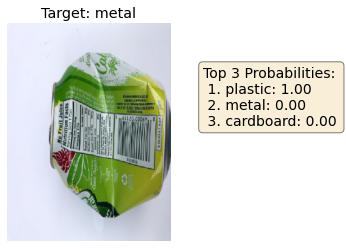

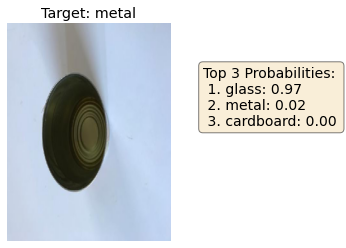

In [148]:
show_incorrect_batch_predictions(model, batch1, labels)

In [239]:
preds = np.argmax(model.predict(holdout_generator), axis=1)

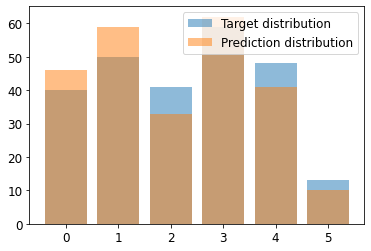

In [240]:
target_dist = Counter(holdout_generator.labels)
prediction_dist = Counter(preds)

plt.bar(list(target_dist.keys()), list(target_dist.values()), alpha=0.5, label='Target distribution')
plt.bar(list(prediction_dist.keys()), list(prediction_dist.values()), alpha=0.5, label='Prediction distribution')
plt.legend();

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [50]:
y_pred = np.argmax(model.predict(holdout_generator), axis=1)

In [51]:
holdout_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

In [52]:
con_mat = confusion_matrix(holdout_generator.classes, y_pred)

In [53]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

In [54]:
con_mat_norm

array([[0.98, 0.  , 0.  , 0.  , 0.02, 0.  ],
       [0.02, 0.8 , 0.12, 0.  , 0.06, 0.  ],
       [0.  , 0.02, 0.95, 0.  , 0.02, 0.  ],
       [0.03, 0.  , 0.03, 0.9 , 0.02, 0.02],
       [0.02, 0.04, 0.04, 0.  , 0.88, 0.02],
       [0.08, 0.  , 0.08, 0.  , 0.  , 0.85]])

In [55]:
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [56]:
con_mat_norm_df = pd.DataFrame(con_mat_norm, index=labels, columns=labels)
con_mat_norm_df

,cardboard,glass,metal,paper,plastic,trash
cardboard,0.98,0.00,0.00,0.0,0.02,0.00
glass,0.02,0.80,0.12,0.0,0.06,0.00
metal,0.00,0.02,0.95,0.0,0.02,0.00
paper,0.03,0.00,0.03,0.9,0.02,0.02
plastic,0.02,0.04,0.04,0.0,0.88,0.02
trash,0.08,0.00,0.08,0.0,0.00,0.85


In [58]:
import seaborn as sns

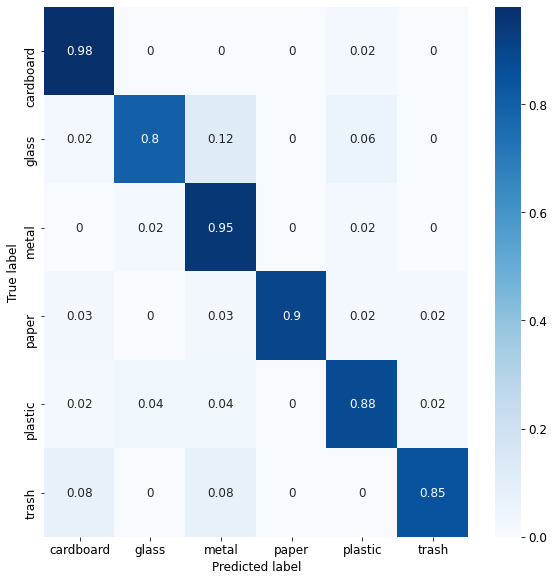

In [59]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [106]:
print(classification_report(holdout_generator.classes, y_pred, target_names=labels))

              precision    recall  f1-score   support

   cardboard       0.89      0.97      0.93        40
       glass       0.93      0.80      0.86        50
       metal       0.78      0.95      0.86        41
       paper       1.00      0.90      0.95        59
     plastic       0.88      0.88      0.88        48
       trash       0.85      0.85      0.85        13

    accuracy                           0.89       251
   macro avg       0.89      0.89      0.89       251
weighted avg       0.90      0.89      0.89       251



In [65]:
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [69]:
bin_holdout_classes = label_binarize(holdout_generator.classes, classes=[0,1,2,3,4,5])
bin_y_pred = label_binarize(y_pred, classes=[0,1,2,3,4,5])

In [79]:
bin_holdout_classes

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [78]:
y_probs = model.predict(holdout_generator)

<ipython-input-92-bee40d4a7d8e>:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


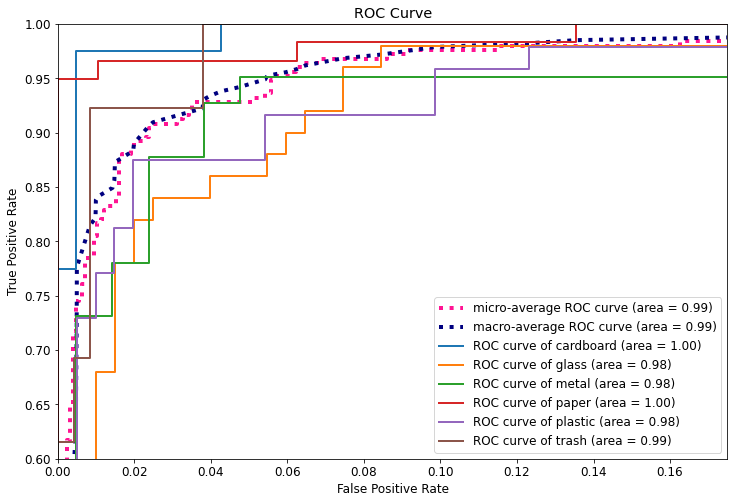

In [92]:
n_classes=6
lw=2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(bin_holdout_classes[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(bin_holdout_classes.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
# plt.figure(1)
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

# plt.plot([0, 1], [0, 1], 'k--', lw=lw)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
# plt.legend(loc="lower right")
# plt.show()


# Zoom in view of the upper left corner.
plt.figure(figsize=(12,8))
plt.xlim(0, 0.175)
plt.ylim(0.6, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

Text(0, 0.5, 'Validation Accuracy')

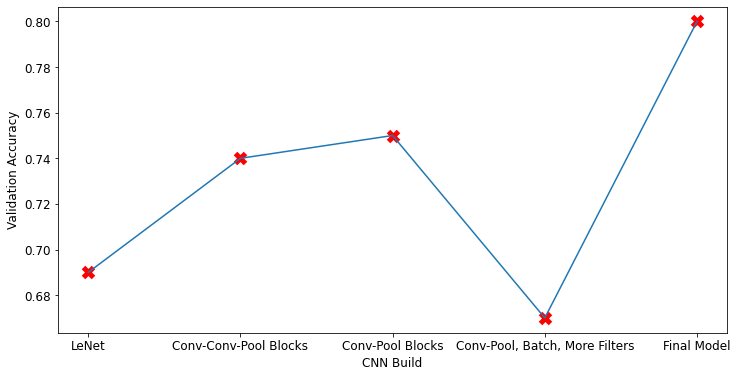

In [118]:
max_val_scores = [.69, .74, .75, .67, .8]
x_labels = ['LeNet', 'Conv-Conv-Pool Blocks', 'Conv-Pool Blocks', 'Conv-Pool, Batch, More Filters', 'Final Model']

plt.figure(figsize=(12,6))
plt.plot(np.arange(1,6), max_val_scores)
plt.xticks([1,2,3,4,5], x_labels)
plt.scatter([1,2,3,4,5], max_val_scores, marker='x', color='r', linewidth=5, s=100)
plt.xlabel('CNN Build')
plt.ylabel('Validation Accuracy')